In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mne
from moabb.datasets import BNCI2014_001
import numpy as np
from ComfyNet import ComfyNet
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from train_test import train, test
from matplotlib import pyplot as plt
from data import get_data
import matplotlib.pyplot as plt
import random
from braindecode.augmentation import AugmentedDataLoader, FrequencyShift, GaussianNoise, ChannelsDropout


<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
d:\Programs\minconda3\envs\serpentine\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
d:\Programs\minconda3\envs\serpentine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupy

In [3]:
mne.set_config("MNE_DATA","bciData")

subjects = [1]
dataset = BNCI2014_001().get_data(subjects=subjects)

In [4]:
class DatasetWrapped(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        # Convert to torch tensors
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return(self.X[idx], self.Y[idx])

sfreq = 250
freq_shift = FrequencyShift(
    probability=0.5,
    sfreq=sfreq,
    max_delta_freq=2.0,  # the frequency shifts are sampled now between -2 and 2 Hz
)

transforms = [freq_shift]


In [5]:
seed = 20231229

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = False
    # torch.cuda.manual_seed_all(seed)
else:
    print("Warning: CUDA is not available on this machine, fallback to CPU.")

# Extract number of chans and time steps from dataset
input_window_samples =1001

bci_ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz', 'EOG1', 'EOG2', 'EOG3', 'stim']
n_classes_bci = 2

def build_model():

    model = ComfyNet(
        n_outputs=n_classes_bci,
        n_chans=len(bci_ch_names[:22]),
        n_filters_time=40,
        filter_time_length=25,
        pool_time_length=75,
        pool_time_stride=15,
        drop_prob=0.5,
        att_depth=1,
        att_heads=10,
        att_drop_prob=0.5,
        return_features=False,
        n_times = input_window_samples,
        final_fc_length = "auto"
    )
    # Send model to GPU
    if cuda:
        model.cuda()
    
    return model

In [6]:
def save_model(model,metrics,optimizer, X_mean, X_std, path):
        torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': metrics[0],
        'train_acc': metrics[1],
        'val_loss': metrics[2],
        'val_acc': metrics[3],
        'X_mean': X_mean,
        'X_std': X_std
    }, f"models/{path}.pt")
  
    

In [63]:
def sweep():
    models = []
    metrics = []
    for i in range(1,10):
        excluded_subject = i
        subjects = [i for i in range(1,10) if i != excluded_subject]
        dataset = BNCI2014_001().get_data(subjects=subjects)
        X, y, X_mean, X_std= get_data(subjects,dataset, normalize = True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
        train_dataset = DatasetWrapped(X_train, y_train)
        val_dataset = DatasetWrapped(X_test, y_test)
        train_dataloader = AugmentedDataLoader(train_dataset, batch_size = 72,transforms = transforms, shuffle = True)
        val_dataloader = AugmentedDataLoader(val_dataset, batch_size = 72, shuffle = False)

        model = build_model()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
        loss = nn.NLLLoss()
        model, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc = train(model, optimizer, loss, train_dataloader, val_dataloader, epochs=200)
        models.append(model)
        metrics.append((avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc))
        save_model(model,metrics[-1],optimizer, X_mean, X_std, f"model_{i}")

    return models, metrics

models , metrics = sweep()

d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(
Epoch 200, Loss: 0.207, Train Accuracy: 0.906, Validation Loss: 0.378, Validation Accuracy: 0.839: 100%|██████████| 200/200 [05:11<00:00,  1.56s/it]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(
Epoch 200, Loss: 0.178, Train Accuracy: 0.927, Validation Loss: 0.457, Validation Accuracy: 0.811: 100%|██████████| 200/200 [05:11<00:00,  1.56s/it]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(
Epoch 200, Loss: 0.168, Train Accuracy: 0.928, Validation Loss: 0.453, Validation Accuracy: 0.833: 100%|█

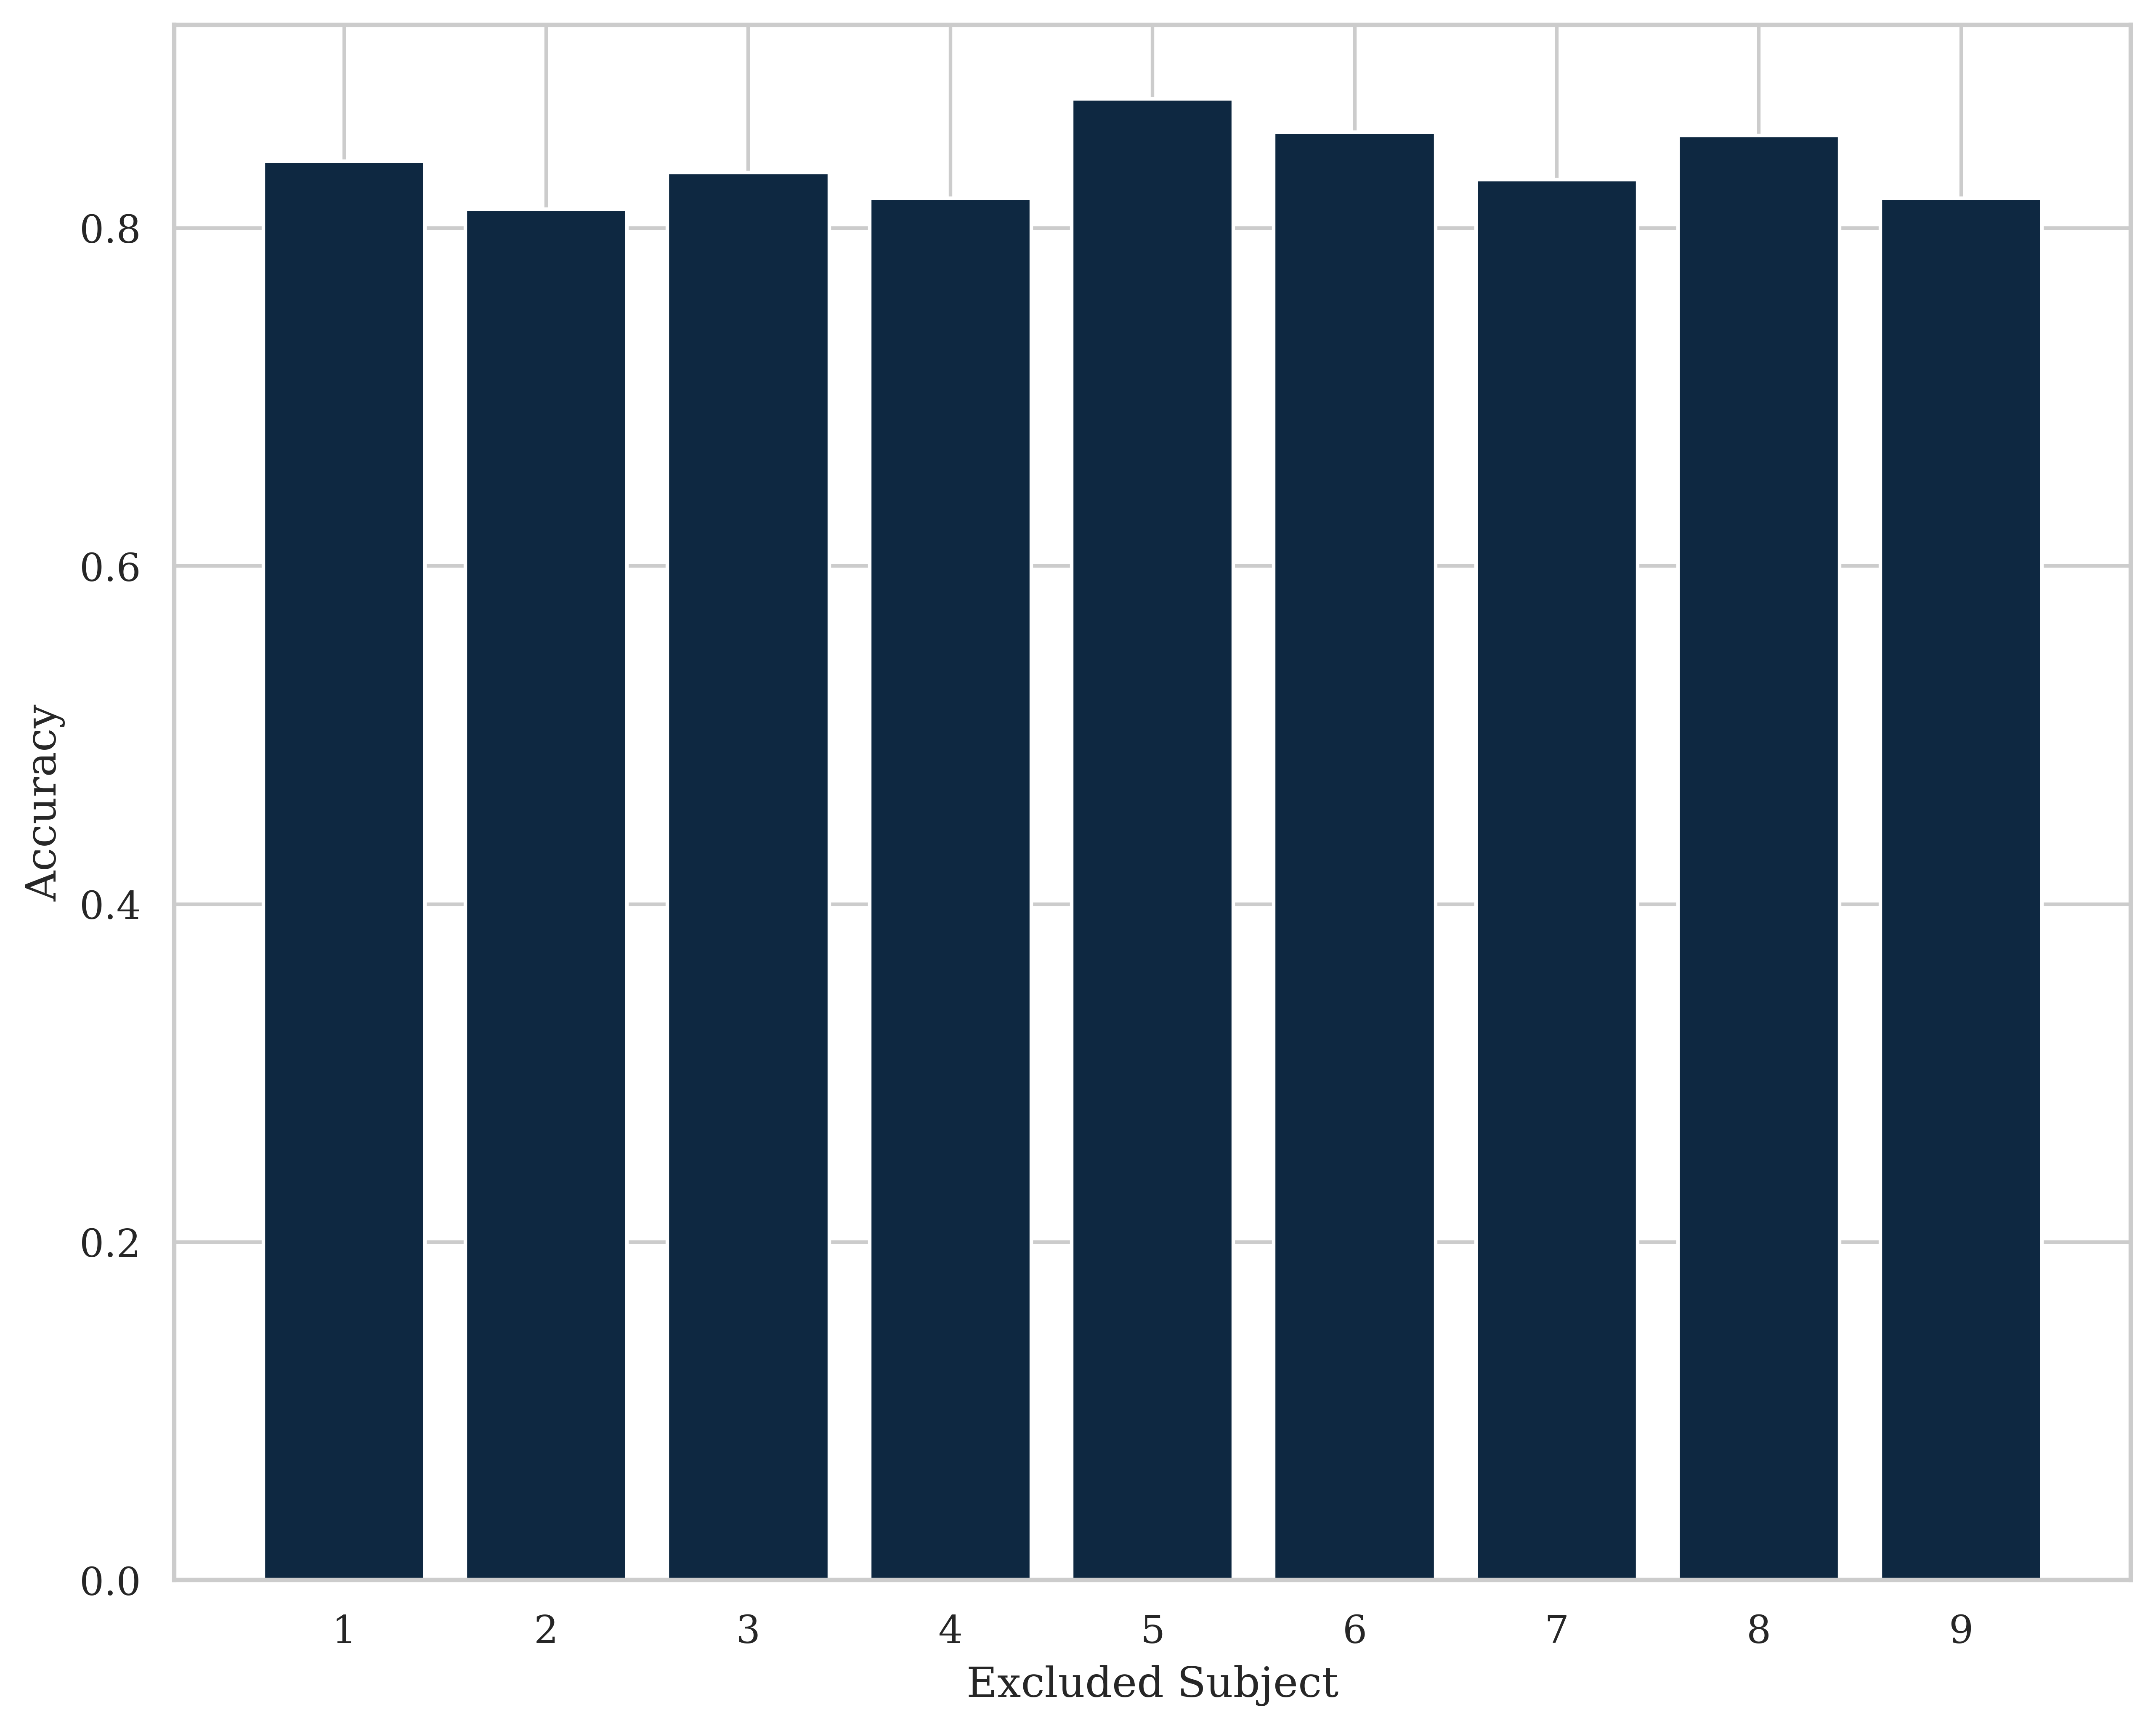

In [8]:
val_accs = []
for i in range(1,10):
    checkpoint = torch.load(f"models/model_{i}.pt")
    val_acc = checkpoint['val_acc']
    val_accs.append(val_acc)

fig = plt.figure(figsize=(10,8), dpi = 600)
plt.bar(range(1,10),val_accs, color='#0e2841')
plt.xlabel("Excluded Subject")
plt.ylabel("Accuracy")  
plt.xticks(range(1,10));
fig.savefig("Images/excluded_subjects.png")


In [9]:
from copy import deepcopy
def finetune():

    before_finetune_accs = []
    after_finetune_val_accs = []
    before_finetune_val_accs = []
    for i in range(1,10):
        print("Tuning for subject ", i, "...")
        checkpoint = torch.load(f"models/model_{i}.pt")
        model = build_model()   
        model.load_state_dict(checkpoint['model_state_dict'])
        finetune_model = deepcopy(model)
        optimizer = torch.optim.AdamW(finetune_model.parameters(), lr=10e-5)
        loss = nn.NLLLoss()
        subjects = [i]
        dataset = BNCI2014_001().get_data(subjects=subjects)
        X, y = get_data(subjects,dataset, normalize = False)
        X_norm = (X - checkpoint['X_mean']) / checkpoint['X_std']
        test_dataset = DatasetWrapped(X_norm, y)
        test_dataloader = AugmentedDataLoader(test_dataset, batch_size = 16, shuffle = False)

        test_loss, test_acc = test(model, loss, test_dataloader)
        before_finetune_accs.append(test_acc)

        X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, shuffle=True)
        train_dataset = DatasetWrapped(X_train, y_train)
        val_dataset = DatasetWrapped(X_test, y_test)
        train_dataloader = AugmentedDataLoader(train_dataset, batch_size = 32,transforms = transforms, shuffle = True)
        val_dataloader = AugmentedDataLoader(val_dataset, batch_size = 32, shuffle = False)
        finetune_model, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc = train(finetune_model, optimizer, loss, train_dataloader, val_dataloader, epochs=40)
        finetune_test_loss, finetune_test_acc = test(finetune_model, loss, val_dataloader)
        after_finetune_val_accs.append(finetune_test_acc)
        before_finetune_test_loss, before_finetune_acc = test(model, loss, val_dataloader)
        before_finetune_val_accs.append(before_finetune_acc)
        torch.save(finetune_model.state_dict(), f"finetune_models/finetuned_model_{i}.pt")
    
    return before_finetune_accs, after_finetune_val_accs, before_finetune_val_accs

before_finetune_accs, after_finetune_val_accs, before_finetune_val_accs = finetune()

Tuning for subject  1 ...


d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(
  0%|          | 0/18 [00:00<?, ?it/s]d:\Programs\minconda3\envs\serpentine\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 18/18 [00:00<00:00, 18.53it/s]


Test Loss: 0.466, Test Accuracy: 0.872


Epoch 40, Loss: 0.048, Train Accuracy: 0.983, Validation Loss: 0.183, Validation Accuracy: 0.931: 100%|██████████| 40/40 [00:09<00:00,  4.11it/s]
100%|██████████| 2/2 [00:00<00:00, 222.26it/s]


Test Loss: 0.197, Test Accuracy: 0.931


100%|██████████| 2/2 [00:00<00:00, 199.98it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 0.649, Test Accuracy: 0.845
Tuning for subject  2 ...


100%|██████████| 18/18 [00:00<00:00, 276.12it/s]


Test Loss: 3.313, Test Accuracy: 0.497


Epoch 40, Loss: 0.315, Train Accuracy: 0.883, Validation Loss: 0.596, Validation Accuracy: 0.724: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s]
100%|██████████| 2/2 [00:00<00:00, 222.14it/s]


Test Loss: 0.383, Test Accuracy: 0.862


100%|██████████| 2/2 [00:00<00:00, 222.21it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 2.653, Test Accuracy: 0.603
Tuning for subject  3 ...


100%|██████████| 18/18 [00:00<00:00, 235.24it/s]


Test Loss: 0.408, Test Accuracy: 0.816


Epoch 40, Loss: 0.100, Train Accuracy: 0.970, Validation Loss: 0.046, Validation Accuracy: 0.983: 100%|██████████| 40/40 [00:09<00:00,  4.30it/s]
100%|██████████| 2/2 [00:00<00:00, 249.95it/s]


Test Loss: 0.009, Test Accuracy: 1.000


100%|██████████| 2/2 [00:00<00:00, 210.25it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 0.314, Test Accuracy: 0.862
Tuning for subject  4 ...


100%|██████████| 18/18 [00:00<00:00, 238.39it/s]


Test Loss: 1.549, Test Accuracy: 0.604


Epoch 40, Loss: 0.343, Train Accuracy: 0.835, Validation Loss: 0.314, Validation Accuracy: 0.914: 100%|██████████| 40/40 [00:09<00:00,  4.34it/s]
100%|██████████| 2/2 [00:00<00:00, 222.21it/s]


Test Loss: 0.281, Test Accuracy: 0.897


100%|██████████| 2/2 [00:00<00:00, 181.85it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 1.095, Test Accuracy: 0.707
Tuning for subject  5 ...


100%|██████████| 18/18 [00:00<00:00, 250.01it/s]


Test Loss: 5.649, Test Accuracy: 0.500


Epoch 40, Loss: 0.464, Train Accuracy: 0.743, Validation Loss: 0.596, Validation Accuracy: 0.741: 100%|██████████| 40/40 [00:09<00:00,  4.33it/s]
100%|██████████| 2/2 [00:00<00:00, 250.00it/s]


Test Loss: 0.473, Test Accuracy: 0.810


100%|██████████| 2/2 [00:00<00:00, 222.24it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 5.397, Test Accuracy: 0.534
Tuning for subject  6 ...


100%|██████████| 18/18 [00:00<00:00, 227.00it/s]


Test Loss: 6.337, Test Accuracy: 0.507


Epoch 40, Loss: 0.362, Train Accuracy: 0.839, Validation Loss: 0.620, Validation Accuracy: 0.741: 100%|██████████| 40/40 [00:09<00:00,  4.30it/s]
100%|██████████| 2/2 [00:00<00:00, 200.02it/s]


Test Loss: 0.413, Test Accuracy: 0.810


100%|██████████| 2/2 [00:00<00:00, 199.85it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 5.768, Test Accuracy: 0.552
Tuning for subject  7 ...


100%|██████████| 18/18 [00:00<00:00, 229.30it/s]


Test Loss: 2.945, Test Accuracy: 0.497


Epoch 40, Loss: 0.234, Train Accuracy: 0.917, Validation Loss: 0.436, Validation Accuracy: 0.845: 100%|██████████| 40/40 [00:09<00:00,  4.30it/s]
100%|██████████| 2/2 [00:00<00:00, 250.02it/s]


Test Loss: 0.294, Test Accuracy: 0.897


100%|██████████| 2/2 [00:00<00:00, 222.26it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 4.071, Test Accuracy: 0.448
Tuning for subject  8 ...


100%|██████████| 18/18 [00:00<00:00, 283.42it/s]


Test Loss: 0.849, Test Accuracy: 0.785


Epoch 40, Loss: 0.184, Train Accuracy: 0.926, Validation Loss: 0.287, Validation Accuracy: 0.879: 100%|██████████| 40/40 [00:09<00:00,  4.30it/s]
100%|██████████| 2/2 [00:00<00:00, 222.21it/s]


Test Loss: 0.319, Test Accuracy: 0.914


100%|██████████| 2/2 [00:00<00:00, 222.29it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 0.671, Test Accuracy: 0.828
Tuning for subject  9 ...


100%|██████████| 18/18 [00:00<00:00, 215.51it/s]


Test Loss: 0.630, Test Accuracy: 0.812


Epoch 40, Loss: 0.059, Train Accuracy: 0.974, Validation Loss: 0.275, Validation Accuracy: 0.897: 100%|██████████| 40/40 [00:09<00:00,  4.29it/s]
100%|██████████| 2/2 [00:00<00:00, 249.97it/s]


Test Loss: 0.241, Test Accuracy: 0.914


100%|██████████| 2/2 [00:00<00:00, 200.04it/s]

Test Loss: 0.525, Test Accuracy: 0.845


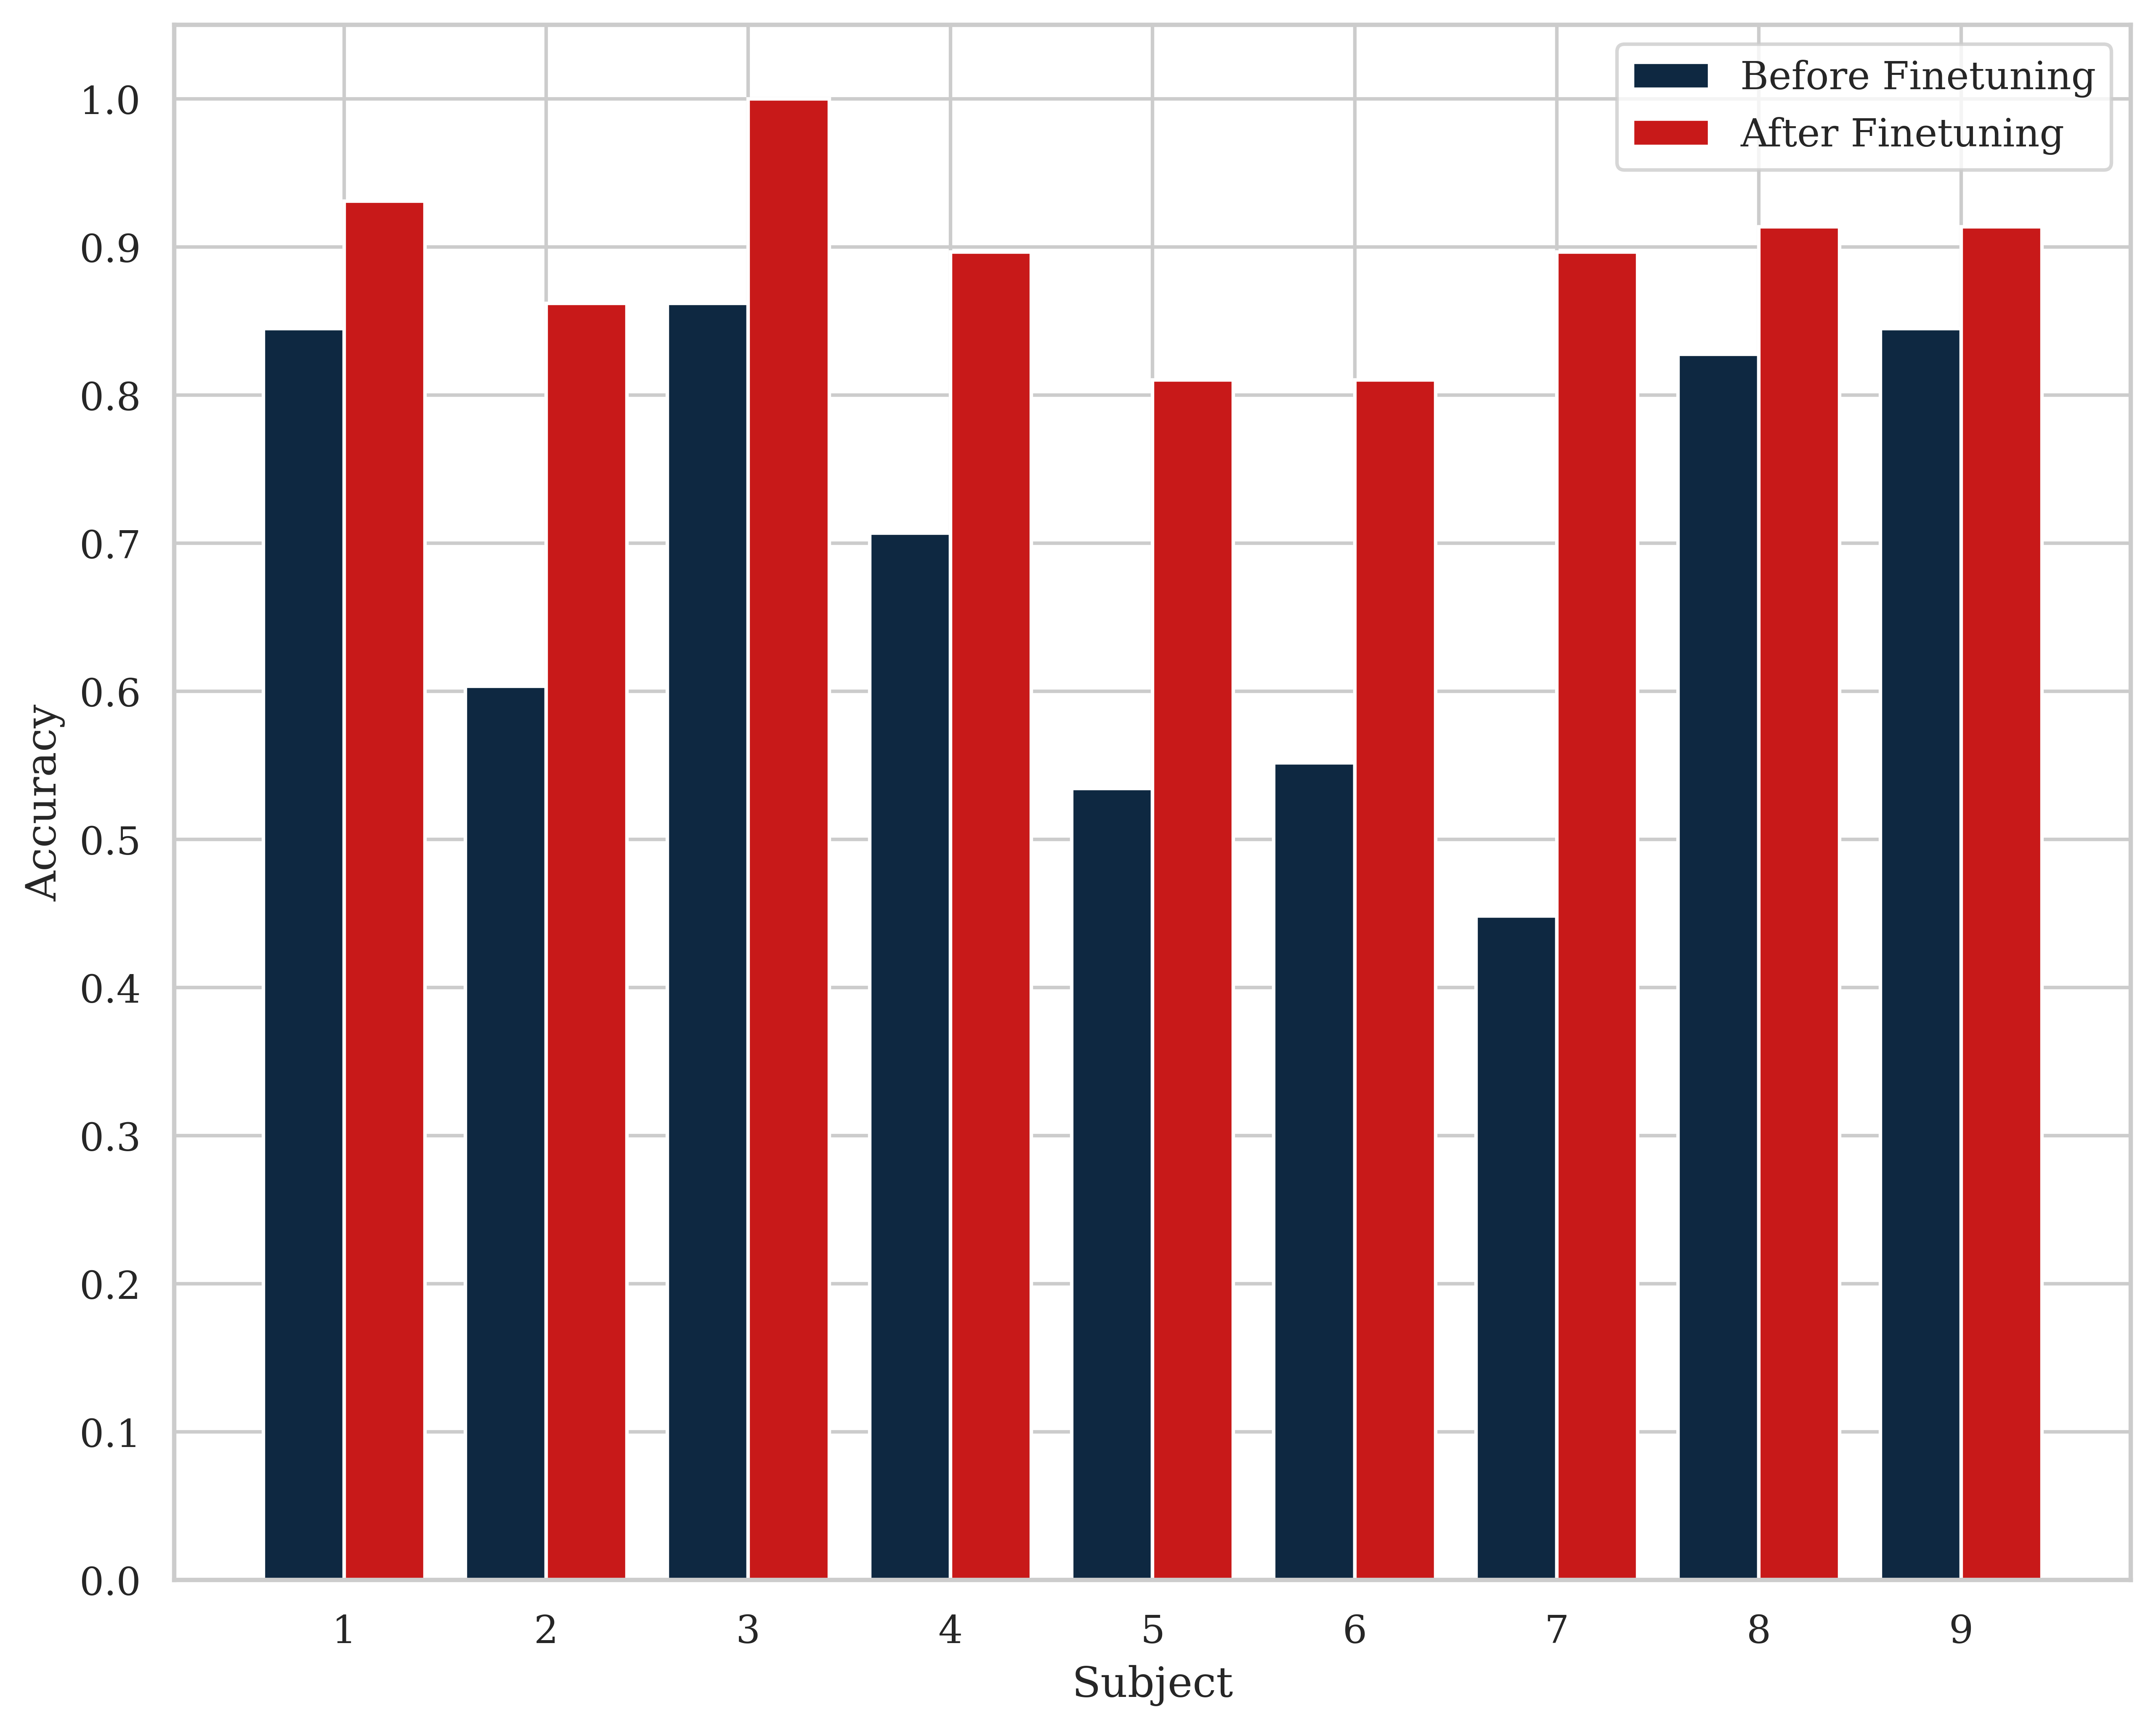

In [11]:
# plot comparitive bar graph between befor_finetune_val_accs and after_finetune_val_accs
X = np.arange(1,10)
width = 0.4
fig = plt.figure(figsize=(10,8), dpi = 600)
plt.bar(X ,before_finetune_val_accs, width, label = "Before Finetuning", color  ='#0e2841')
plt.bar(X+width,after_finetune_val_accs,width, label = "After Finetuning", color = '#c81919')
plt.xlabel("Subject")
plt.ylabel("Accuracy")
plt.legend()
plt.yticks(np.arange(0,1.1,0.1));
plt.xticks(X+width/2, X);
plt.savefig("Images/finetune.png")

In [72]:
(np.array(after_finetune_val_accs) - np.array(before_finetune_val_accs)).mean()

0.18773946360153257

In [12]:
def test_sweep():
    models = []
    val_test_accs = []
    for i in range(1,10):
        checkpoint = torch.load(f"finetune_models/finetuned_model_{i}.pt")
        model = build_model()
        model.load_state_dict(checkpoint)
        excluded_subject = i
        subjects = [i for i in range(1,10) if i != excluded_subject]
        dataset = BNCI2014_001().get_data(subjects=subjects)
        X, y, X_mean, X_std= get_data(subjects,dataset, normalize = True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)
        train_dataset = DatasetWrapped(X_train, y_train)
        val_dataset = DatasetWrapped(X_test, y_test)
        val_dataloader = AugmentedDataLoader(val_dataset, batch_size = 72, shuffle = False)
        loss = nn.NLLLoss()
        val_test_loss, val_test_acc = test(model, loss, val_dataloader)
        val_test_accs.append(val_test_acc)

    return val_test_accs

val_test_accs = test_sweep()

d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(
  0%|          | 0/7 [00:00<?, ?it/s]d:\Programs\minconda3\envs\serpentine\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 7/7 [00:00<00:00, 19.54it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 0.897, Test Accuracy: 0.772


100%|██████████| 7/7 [00:00<00:00, 17.39it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 1.513, Test Accuracy: 0.579


100%|██████████| 7/7 [00:00<00:00, 67.14it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 0.723, Test Accuracy: 0.816


100%|██████████| 7/7 [00:00<00:00, 23.37it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 0.901, Test Accuracy: 0.744


100%|██████████| 7/7 [00:00<00:00, 19.83it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 1.440, Test Accuracy: 0.570


100%|██████████| 7/7 [00:00<00:00, 28.17it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 1.862, Test Accuracy: 0.581


100%|██████████| 7/7 [00:00<00:00, 20.19it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 0.890, Test Accuracy: 0.711


100%|██████████| 7/7 [00:00<00:00, 29.52it/s]
d:\Documents\Projects\Serpentine\comfynet-bci\base.py:175: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn(


Test Loss: 0.837, Test Accuracy: 0.714


100%|██████████| 7/7 [00:00<00:00, 20.76it/s]

Test Loss: 1.529, Test Accuracy: 0.614


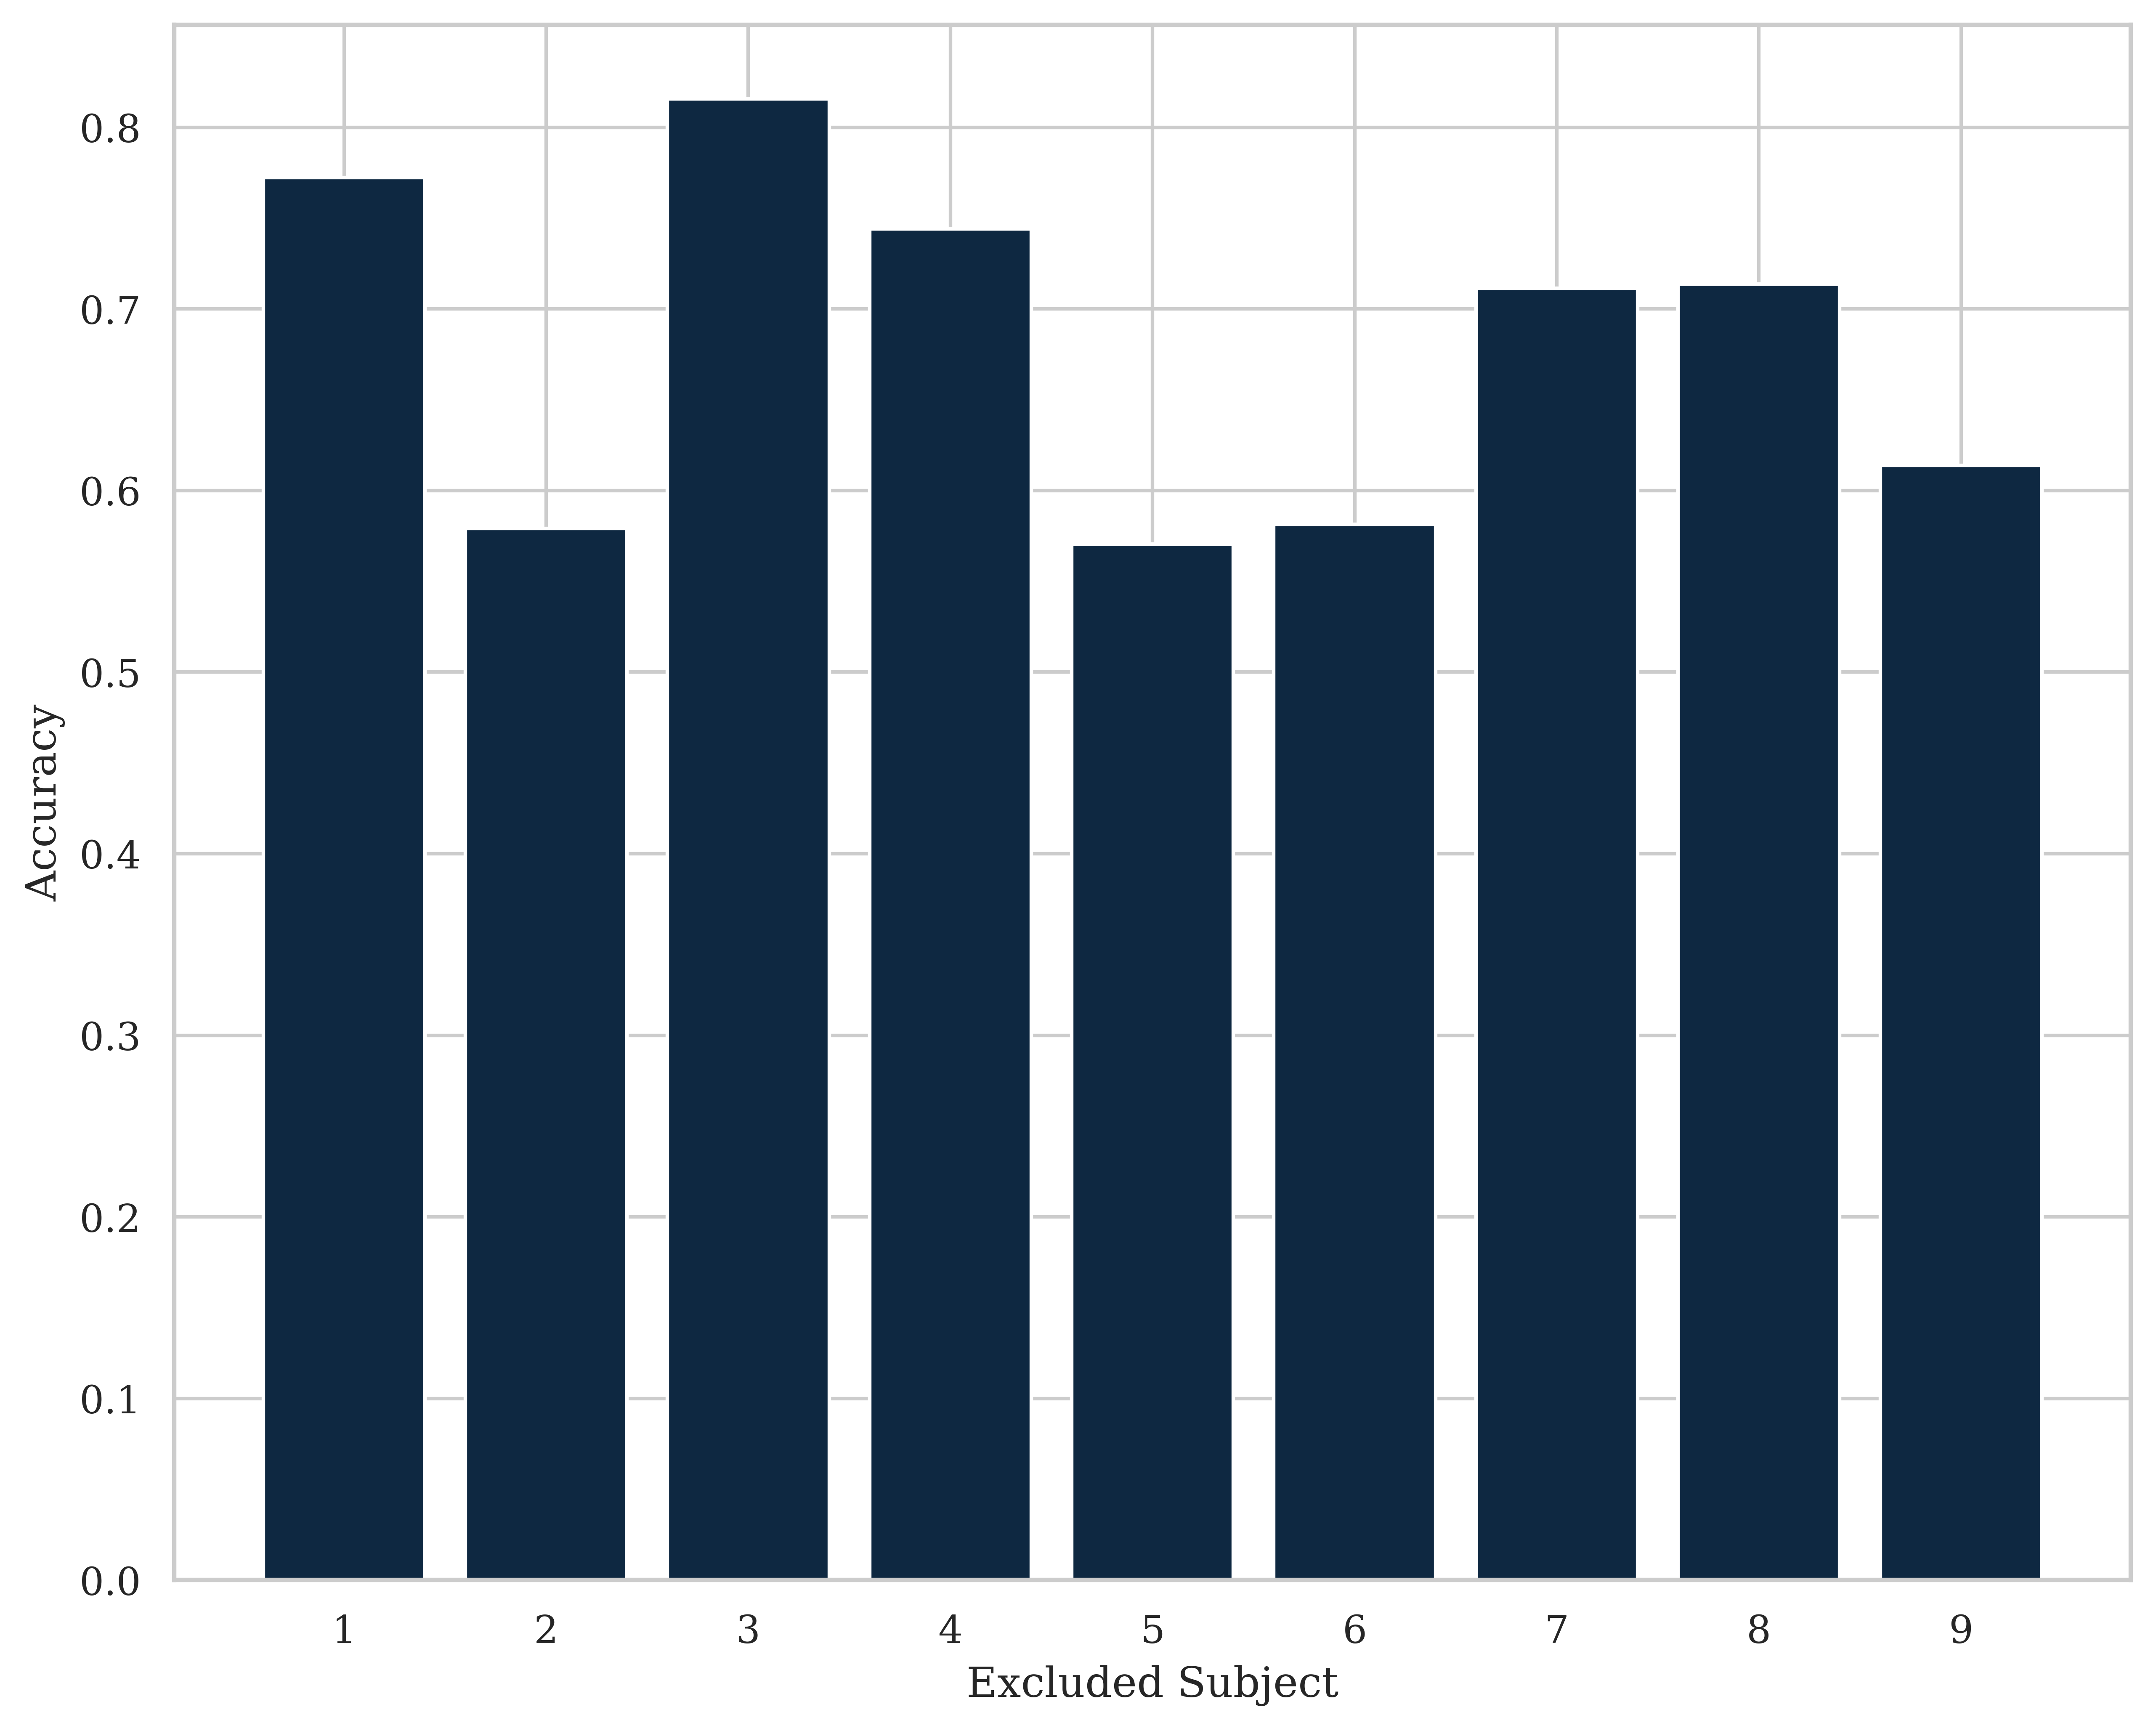

In [13]:
fig = plt.figure(figsize=(10,8), dpi = 600)
plt.bar(range(1,10),val_test_accs, color='#0e2841')
plt.xlabel("Excluded Subject")
plt.ylabel("Accuracy")  
plt.xticks(range(1,10));
fig.savefig("Images/val_test.png")